/Users/liuliangjie/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[*********************100%***********************]  1 of 1 completed
/var/folders/vt/qwvfy06n63q184jd56rxd3dh0000gn/T/ipykernel_12906/2846989490.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wealth_history[i, t] = agent.real_wealth


Best wealth ratio: 5.32
Average wealth ratio: 1.30
Worst wealth ratio: 0.00


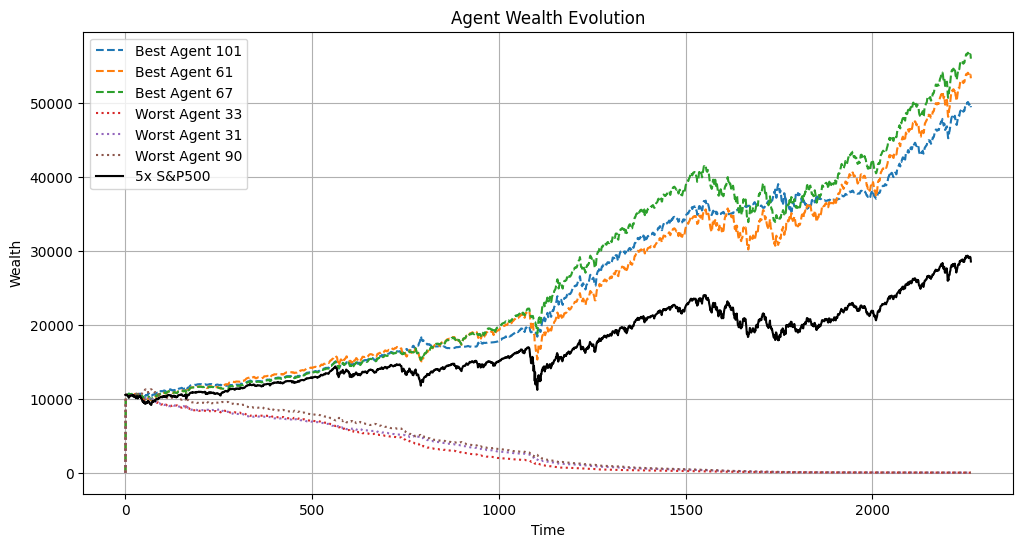

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import random

class Strategy:
    def __init__(self, m, initial_price):
        self.m = m
        self.num_states = 2 ** m
        self.decisions = np.random.choice([-1, 0, 1], size=self.num_states)
        self.virtual_wealth = 5 * initial_price
        self.virtual_position = 0
        
    def get_decision(self, state):
        return self.decisions[state]
    
    def update_virtual_position_and_wealth(self, decision, price, prev_price):
        new_position = self.virtual_position + decision
        position_limit = self.virtual_wealth / price
        self.virtual_position = np.clip(new_position, -position_limit, position_limit)
        self.virtual_wealth += self.virtual_position * (price - prev_price)

class Agent:
    def __init__(self, num_strategies, m, initial_price):
        all_strategies = [Strategy(m, initial_price) for _ in range(2 ** m)]
        self.strategies = random.sample(all_strategies, num_strategies)
        self.real_wealth = 5 * initial_price
        self.real_position = 0
        
    def choose_best_strategy(self):
        return np.argmax([s.virtual_wealth for s in self.strategies])

class WealthGame:
    def __init__(self, n_agents=101, m=3, s=2, beta=0.5):
        self.n_agents = n_agents
        self.m = m
        self.s = s
        self.beta = beta
        self.current_state = 0
        
    def download_data(self):
        sp500 = yf.download('^GSPC', start='2015-11-01', end='2024-11-01')
        self.prices = sp500['Close'].values
        self.transaction_prices = self._calculate_transaction_prices()
        
    def _calculate_transaction_prices(self):
        p_t = np.zeros_like(self.prices)
        p_t[0] = self.prices[0]
        for t in range(len(self.prices) - 1):
            p_t[t + 1] = self.prices[t] + self.beta * (self.prices[t + 1] - self.prices[t])
        return p_t
    
    def update_state(self, price_change):
        bit = 1 if price_change > 0 else 0
        self.current_state = (2 * self.current_state + bit) % (2 ** self.m)
        return self.current_state
    
    def run_simulation(self):
        self.download_data()
        self.agents = [Agent(self.s, self.m, self.prices[0]) for _ in range(self.n_agents)]
        wealth_history = np.zeros((self.n_agents, len(self.prices)))
        
        for t in range(1, len(self.prices)):
            price_change = self.prices[t] - self.prices[t-1]
            current_state = self.update_state(price_change)
            
            for i, agent in enumerate(self.agents):
                strategy_idx = agent.choose_best_strategy()
                strategy = agent.strategies[strategy_idx]
                
                # Update virtual wealth of all strategies
                for strategy in agent.strategies:
                    decision = strategy.get_decision(current_state)
                    strategy.update_virtual_position_and_wealth(decision, self.prices[t], self.prices[t-1])
                
                # Update agent's wealth and position
                decision = strategy.get_decision(current_state)
                new_position = agent.real_position + decision
                position_limit = agent.real_wealth / self.prices[t]
                agent.real_position = np.clip(new_position, -position_limit, position_limit)
                agent.real_wealth += agent.real_position * (self.transaction_prices[t] - self.transaction_prices[t-1])
                wealth_history[i, t] = agent.real_wealth
        
        return wealth_history

    def analyze_results(self, wealth_history):
        initial_wealth = 5 * self.prices[0]
        final_wealth_ratio = wealth_history[:, -1] / initial_wealth
        best_agents = np.argsort(final_wealth_ratio)[-3:]
        worst_agents = np.argsort(final_wealth_ratio)[:3]
        
        print(f"Best wealth ratio: {final_wealth_ratio[best_agents[-1]]:.2f}")
        print(f"Average wealth ratio: {np.mean(final_wealth_ratio):.2f}")
        print(f"Worst wealth ratio: {final_wealth_ratio[worst_agents[0]]:.2f}")
        
        plt.figure(figsize=(12, 6))
        for agent_idx in best_agents:
            plt.plot(wealth_history[agent_idx], label=f'Best Agent {agent_idx+1}', linestyle='--')
        for agent_idx in worst_agents:
            plt.plot(wealth_history[agent_idx], label=f'Worst Agent {agent_idx+1}', linestyle=':')
        plt.plot(5 * self.prices, label='5x S&P500', color='black')
        plt.xlabel('Time')
        plt.ylabel('Wealth')
        plt.title('Agent Wealth Evolution')
        plt.legend()
        plt.grid(True)
        plt.show()

def main():
    np.random.seed(42)
    random.seed(42)
    
    game = WealthGame()
    wealth_history = game.run_simulation()
    game.analyze_results(wealth_history)

if __name__ == "__main__":
    main()

**Observations and Discussions**

1. What types of agents are more likely to win?
 - Consistency and trend-following: The best-performing agents (e.g., Agent 101 and Agent 61) exhibit steady wealth growth, likely due to consistent strategies that align with market trends.
 - Avoiding over-trading: Poor-performing agents (e.g., Agent 33 and Agent 31) often lose wealth quickly, possibly due to overly aggressive or frequent trading.
 - Wealth management: Winning agents effectively manage their positions, avoiding excessive exposure relative to their wealth.

2. Do strategies need to adapt to changing environments?
 - Adaptability matters: Strategies need to adjust during market transitions, such as from trending to volatile periods. Winning agents likely reduced positions during volatile periods to minimize losses.
 - Balanced approaches: Combining long-term strategies with short-term adjustments can optimize performance in different market conditions.

3. Which strategies perform better in trending vs. volatile markets?
 - Trending markets: Agents with trend-following strategies, such as buying and holding during uptrends, perform the best (e.g., Agent 101 and Agent 61).
 - Volatile markets: Poor performers often use high-frequency or contrarian strategies, leading to rapid losses. Better agents adopt conservative or neutral strategies to limit downside.

**Summary**

Winning agents balance consistency and adaptability, leveraging trends while protecting wealth in volatile conditions. Over-trading and excessive risk-taking are key drivers of losses. Strategies that respond to market conditions tend to achieve long-term success.